In [1]:
import pandas as pd

# Creating the dataframe from the given information
data = {
    "Content": [
        "get cheap pills online",
        "online pharmacy pills fast",
        "online pills fast shipment",
        "my pills prescription",
        "shipment not fast",
        "order pills online",
        "fast pills delivery",
        "this online pharmacy",
        "take your pills",
        "get your pills cheap",
        "my online order"
    ],
    "Category": [
        "SPAM",
        "SPAM",
        "SPAM",
        "HAM",
        "HAM",
        "SPAM",
        "SPAM",
        "HAM",
        "HAM",
        "SPAM",
        "HAM"
    ]
}

df = pd.DataFrame(data)
df

,Content,Category
0,get cheap pills online,SPAM
1,online pharmacy pills fast,SPAM
2,online pills fast shipment,SPAM
3,my pills prescription,HAM
4,shipment not fast,HAM
5,order pills online,SPAM
6,fast pills delivery,SPAM
7,this online pharmacy,HAM
8,take your pills,HAM
9,get your pills cheap,SPAM


In [2]:
df['Category'] = df['Category'].map({'SPAM': 0, 'HAM': 1})
df

,Content,Category
0,get cheap pills online,0
1,online pharmacy pills fast,0
2,online pills fast shipment,0
3,my pills prescription,1
4,shipment not fast,1
5,order pills online,0
6,fast pills delivery,0
7,this online pharmacy,1
8,take your pills,1
9,get your pills cheap,0


In [3]:
df.columns = ['X', 'Y']
df

,X,Y
0,get cheap pills online,0
1,online pharmacy pills fast,0
2,online pills fast shipment,0
3,my pills prescription,1
4,shipment not fast,1
5,order pills online,0
6,fast pills delivery,0
7,this online pharmacy,1
8,take your pills,1
9,get your pills cheap,0


In [5]:
vocabulary = df['X'].str.split(expand=True).stack().unique().tolist()
vocabulary

['get',
 'cheap',
 'pills',
 'online',
 'pharmacy',
 'fast',
 'shipment',
 'my',
 'prescription',
 'not',
 'order',
 'delivery',
 'this',
 'take',
 'your']

In [27]:
# step 2 get bag of words
from scipy.sparse import lil_matrix
from nltk.tokenize import word_tokenize
# Assuming 'vocabulary' is a list of unique words
vocabulary_index = {word: i for i, word in enumerate(vocabulary)}

# Create a function to create a binary bag of words using a sparse matrix
def create_sparse_binary_bag_of_words(text, vocabulary_index):
    # Initialize a sparse matrix with dimensions (1, len(vocabulary))
    bag_of_words_sparse = lil_matrix((1, len(vocabulary_index)))
#     words = text.split()
    words = word_tokenize(text)
    for word in words:
        if word in vocabulary_index:
            bag_of_words_sparse[0, vocabulary_index[word]] = 1
    return bag_of_words_sparse

# Apply the function to each review in your training set
# This will create a list of sparse matrices (one for each review)
sparse_bows = df['X'].apply(lambda x: create_sparse_binary_bag_of_words(x, vocabulary_index))

# Now, you can combine these into a single sparse matrix
from scipy.sparse import vstack
X_train = vstack(sparse_bows)
X_train

<11x15 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in COOrdinate format>

In [26]:
y_train = df['Y']
y_train

0     0
1     0
2     0
3     1
4     1
5     0
6     0
7     1
8     1
9     0
10    1
Name: Y, dtype: int64

In [39]:
# step 3 construct model
num_rows = len(df)
num_rows_positive = (df['Y'] == 1).sum()
num_rows_negative = (df['Y'] == 0).sum()
probability_positive = num_rows_positive/num_rows
probability_negative = num_rows_negative/num_rows
probability_positive, probability_negative

(0.45454545454545453, 0.5454545454545454)

In [30]:
y_train_array = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train
y_train_array

array([0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1], dtype=int64)

In [48]:
df['Word_Count'] = df['X'].apply(lambda x: len(word_tokenize(x)))
word_count_by_y = df.groupby('Y')['Word_Count'].sum()

word_count_by_y

Y
0    22
1    15
Name: Word_Count, dtype: int64

In [47]:
import numpy as np
X_train_coo = X_train.tocoo()
feature_counts_positive = np.zeros(X_train.shape[1])
feature_counts_negative = np.zeros(X_train.shape[1])

for i, j, v in zip(X_train_coo.row, X_train_coo.col, X_train_coo.data):
    if y_train_array[i] == 0:
        feature_counts_negative[j] += v
    else:
        feature_counts_positive[j] += v

# Calculate likelihoods with Laplace smoothing --  this is numpy array
feature_counts_negative = feature_counts_negative + 1
feature_counts_positive = feature_counts_positive + 1
likelihoods_negative = (feature_counts_negative) / (word_count_by_y[0] +  len(vocabulary_index))
likelihoods_positive = (feature_counts_positive) / (word_count_by_y[1] +  len(vocabulary_index))

likelihoods_positive,likelihoods_negative

(array([0.03333333, 0.03333333, 0.1       , 0.1       , 0.06666667,
        0.06666667, 0.06666667, 0.1       , 0.06666667, 0.06666667,
        0.06666667, 0.03333333, 0.06666667, 0.06666667, 0.06666667]),
 array([0.08108108, 0.08108108, 0.18918919, 0.13513514, 0.05405405,
        0.10810811, 0.05405405, 0.02702703, 0.02702703, 0.02702703,
        0.05405405, 0.05405405, 0.02702703, 0.02702703, 0.05405405]))

In [49]:
# prediction
def predict(X_new, probability_negative, probability_positive, likelihoods_negative, likelihoods_positive):
    # Ensure X_new is in COO format
    X_new_coo = X_new.tocoo()
    predictions = np.zeros(X_new.shape[0])
    
    # Log probabilities for numerical stability
    log_probability_negative = np.log(probability_negative)
    log_probability_positive = np.log(probability_positive)
    log_likelihoods_negative = np.log(likelihoods_negative)
    log_likelihoods_positive = np.log(likelihoods_positive)

    # Calculate log posterior probabilities
    for i in range(X_new.shape[0]):
        log_posterior_prob_0 = log_probability_negative
        log_posterior_prob_1 = log_probability_positive
        
        for j in range(X_new_coo.nnz):
            if X_new_coo.row[j] == i:
                feature_index = X_new_coo.col[j]
                log_posterior_prob_0 += log_likelihoods_negative[feature_index]
                log_posterior_prob_1 += log_likelihoods_positive[feature_index]
                
        # Classification based on higher log posterior probability
        predictions[i] = 1 if log_posterior_prob_1 > log_posterior_prob_0 else 0
        
    return predictions

In [50]:
# Creating the 'test_set' DataFrame
test_set_data = {
    "X": [
        "order pills fast",
        "no prescription online pharmacy",
        "this order was online"
    ],
    "Y": ["SPAM", "SPAM", "HAM"]
}

test_set = pd.DataFrame(test_set_data)

# Converting 'Y' values from 'SPAM'/'HAM' to 0/1
test_set['Y'] = test_set['Y'].map({'SPAM': 0, 'HAM': 1})

test_set

,X,Y
0,order pills fast,0
1,no prescription online pharmacy,0
2,this order was online,1


In [51]:
X_test = vectorizer.fit_transform(test_set['X'])
X_test

<3x15 sparse matrix of type '<class 'numpy.int64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [52]:
y_pred_manual = predict(X_test, probability_negative, probability_positive, likelihoods_negative, likelihoods_positive)
y_pred_manual

array([0., 1., 1.])

Accuracy: 0.6666666666666666


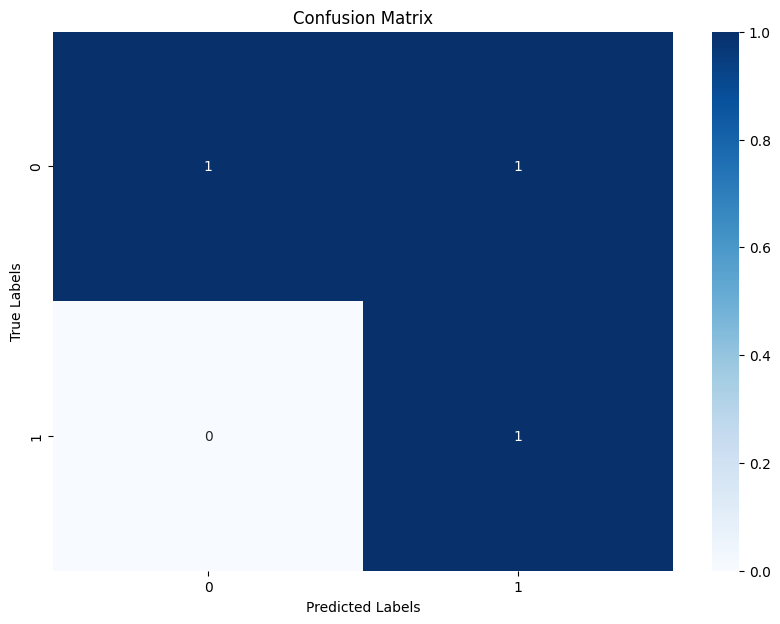

In [54]:
# Calculate and print the accuracy
from sklearn.metrics import accuracy_score
y_test = test_set['Y']
accuracy = accuracy_score(y_test, y_pred_manual)
print(f'Accuracy: {accuracy}')

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_manual)
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title for clarity
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [71]:
def get_and_classify_user_input():
#     user_input = input("Please enter a sentence")
    user_input = "no online pharmacy"
    user_input_data = {user_input}
    user_input_df = pd.DataFrame(user_input_data)
    user_input_s_array = vectorizer.fit_transform(user_input_df[0])
#     user_input_s_array = string_to_sparse_array(user_input)
    return predict(user_input_s_array, probability_negative, probability_positive, likelihoods_negative, likelihoods_positive)

prediction = get_and_classify_user_input() 
prediction

array([0.])